# March 3-10, 2022: emoprox2 approach vs retreat segments classification

In [1]:
import os
import sys
from os.path import join as pjoin

import numpy as np
import pandas as pd
import tensorflow as tf
# import tensorflow_addons as tfa
import pickle, time, random
import neural_structured_learning as nsl
from tqdm import tqdm
import json

# explanation tools
import shap

# plotting
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

# nilearn
from nilearn import image
from nilearn import masking
from nilearn import plotting

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'explainable-ai')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/mar22"

# folders
sys.path.insert(0, proj_dir)
from helpers.dataset_utils import *
from helpers.base_model import *
from helpers.model_definitions import *

# select the GPU to be used
gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.experimental.set_memory_growth(gpus[1], True)
    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

# print the JS visualization code to the notebook
shap.initjs()

2022-03-11 16:37:06.688169: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-03-11 16:37:08.523167: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-03-11 16:37:08.548793: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:17:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-03-11 16:37:08.549006: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-03-11 16:37:08.549034: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
202

## data 

In [2]:
def get_data_samples_actual(data, subject_list):
    
    X = []; y = []
    target = np.expand_dims(np.array([0,0,0,0,0,0,0,1,1,1,1,1]),axis=0).astype(np.float64)
    
    for subject in subject_list:
        
        num_samples = data[subject].shape[0]
        X.append(data[subject])
        y.append(np.repeat(target, num_samples, axis=0))

    return np.vstack(X), np.vstack(y)

def get_data_samples_avg(data, subject_list):
    
    X = []; y = []
    target = np.expand_dims(np.array([0,0,0,0,0,0,0,1,1,1,1,1]),axis=0).astype(np.float64)
    
    for subject in subject_list:
        
        num_samples = data[subject].shape[0]
        X.append(np.expand_dims(np.mean(data[subject], axis=0), axis=0))
        y.append(target)

    return np.vstack(X), np.vstack(y)

In [3]:
raw_data_file = f"{proj_dir}/data/classification_data/MAX_rois_122subjs_nearmiss_segments_withoutshock.pkl"
with open(raw_data_file, 'rb') as f:
    data = pickle.load(f)

### parameters

In [4]:
class ARGS(): pass
args = ARGS()

args.SEED = 74

# data
args.num_subjects = len(data.keys())
args.num_train = args.num_subjects // 2
args.num_test = args.num_subjects - args.num_train

### organizing into tensors

In [5]:
subject_list = list(data.keys())
random.Random(args.SEED).shuffle(subject_list)

train_list = subject_list[:args.num_train]
test_list = subject_list[-args.num_test:]

X_train, y_train = get_data_samples_actual(data, train_list)
X_test, y_test = get_data_samples_actual(data, test_list)

X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)
X_test = tf.convert_to_tensor(X_test)
y_test = tf.convert_to_tensor(y_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2137, 12, 85) (2137, 12) (2167, 12, 85) (2167, 12)


2022-03-11 16:37:08.616820: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-11 16:37:08.618023: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-03-11 16:37:08.618377: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 1
2022-03-11 16:37:08.618423: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-03-11 16:37:08.997712: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect St

## model

In [6]:
# model
args.num_units = 32
args.num_classes = 2 # for binary classification
args.l2 = 1e-2
args.dropout = 0.8
args.learning_rate = 4e-4

args.num_epochs = 100
args.validation_split = 0.2
args.batch_size = 64

# multiplier to adversarial regularization loss. Defaults to 0.2. 
args.adv_multiplier = 1
# step size to find the adversarial sample. Defaults to 0.001. 
args.adv_step_size = 3
# type of tensor norm to normalize the gradient. Defaults to L2 norm. 
# Input will be converted to NormType when applicable 
# (e.g., a value of 'l2' will be converted to nsl.configs.NormType.L2). 
args.adv_grad_norm = 'l2'

args.temp = 20

### response of near miss segment (proof of concept)

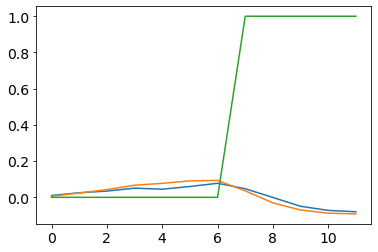

In [7]:
import matplotlib.pyplot as plt
plt.plot(np.mean(np.mean(X_train,axis=2), axis=0))
plt.plot(np.mean(np.mean(X_test,axis=2), axis=0))
plt.plot(np.mean(y_train, axis=0))


### defining model

In [8]:
tf.random.set_seed(args.SEED)

regularizer = tf.keras.regularizers.l2(l2=args.l2) 
optimizer = tf.keras.optimizers.Adam(learning_rate=args.learning_rate)

model_file = f"{results_dir}/models/GRU_classifier_model"
history_file = f"{results_dir}/models/GRU_classifier_model_history"
if os.path.exists(model_file):
    # load the model
    model = tf.keras.models.load_model(model_file)
    history = json.load(open(f"{history_file}", 'r'))
else:
    # build, train, and save the model
    '''
    build model
    '''
    model = get_GRU_classifier_model(
        X_train, 
        args, 
        regularizer)

    '''
    train model
    '''
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=optimizer,
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

    then = time.time()
    history = model.fit(
        x=X_train, 
        y=y_train,
        batch_size=args.batch_size, 
        epochs=args.num_epochs, 
        verbose=1,
        # callbacks=tf.keras.callbacks.EarlyStopping(patience=5),
        validation_split=args.validation_split, 
        shuffle=True)
    print('--- train time =  %0.4f seconds ---' %(time.time() - then))

    '''
    save model
    '''
    model.save(model_file)
    history = history.history
    json.dump(history, open(f"{history_file}", 'w'))

2022-03-11 16:37:09.407970: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-11 16:37:09.408556: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3699850000 Hz


Epoch 1/100


2022-03-11 16:37:10.715628: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


 3/27 [==>...........................] - ETA: 1s - loss: 2.0167 - sparse_categorical_accuracy: 0.5109 

2022-03-11 16:37:11.072542: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


27/27 [==============================] - 3s 66ms/step - loss: 1.9374 - sparse_categorical_accuracy: 0.5041 - val_loss: 1.7679 - val_sparse_categorical_accuracy: 0.5444
Epoch 2/100
27/27 [==============================] - 2s 57ms/step - loss: 1.7758 - sparse_categorical_accuracy: 0.5078 - val_loss: 1.6187 - val_sparse_categorical_accuracy: 0.5761
Epoch 3/100
27/27 [==============================] - 2s 56ms/step - loss: 1.6256 - sparse_categorical_accuracy: 0.5258 - val_loss: 1.4910 - val_sparse_categorical_accuracy: 0.6018
Epoch 4/100
27/27 [==============================] - 1s 55ms/step - loss: 1.4997 - sparse_categorical_accuracy: 0.5389 - val_loss: 1.3813 - val_sparse_categorical_accuracy: 0.6162
Epoch 5/100
27/27 [==============================] - 2s 58ms/step - loss: 1.3934 - sparse_categorical_accuracy: 0.5437 - val_loss: 1.2853 - val_sparse_categorical_accuracy: 0.6312
Epoch 6/100
27/27 [==============================] - 2s 57ms/step - loss: 1.2992 - sparse_categorical_accuracy: 

2022-03-11 16:39:43.806713: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/govindas/explainable-ai/results/models/GRU_classifier_model/assets


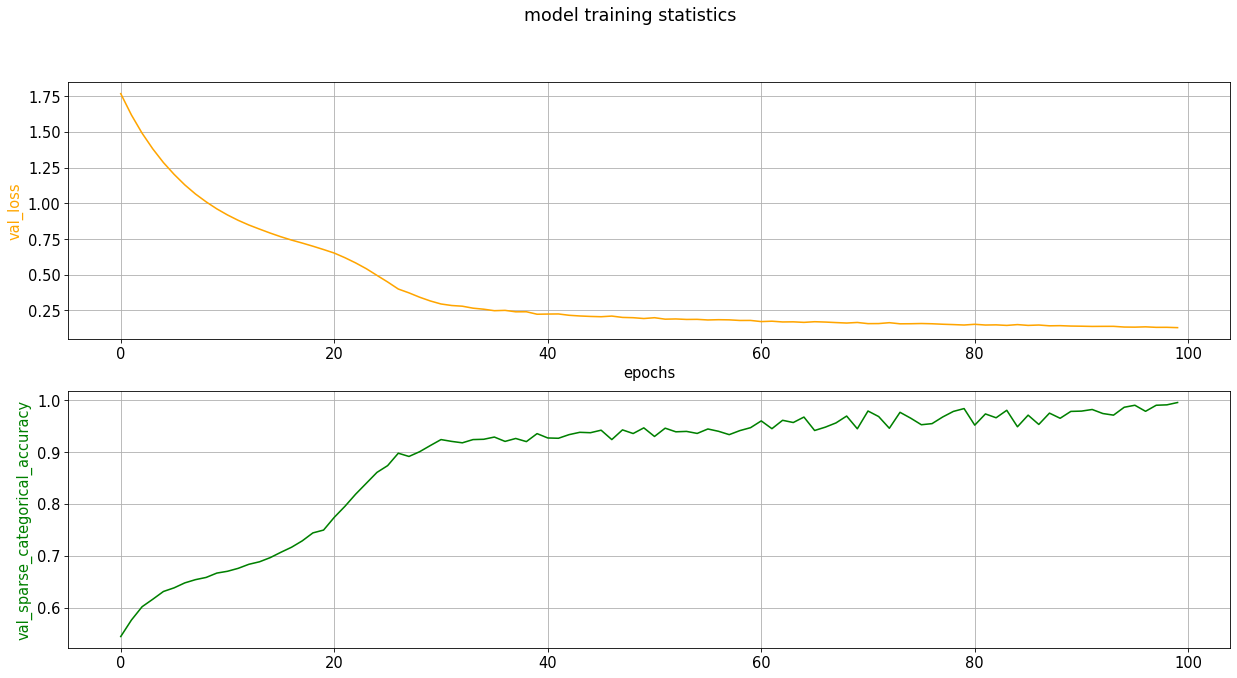

In [9]:
cm = 1 #1/2.54
nrows, ncols = 2, 1
fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(20*ncols*cm, 5*nrows*cm), 
    sharex=False,
    sharey=False,
    dpi=75)

plt.suptitle(f"model training statistics")

ax = axs[0]
ax.plot(history['val_loss'], color='orange')
ax.set_ylabel(f"val_loss", color='orange')
ax.set_xlabel(f"epochs")
ax.grid(True, axis='both')

ax = axs[1]
ax.plot(history['val_sparse_categorical_accuracy'], color='green')
ax.set_ylabel(f"val_sparse_categorical_accuracy", color='green')
ax.grid(True, axis='both')

In [10]:
model.evaluate(X_test, y_test)

68/68 [==============================] - 1s 11ms/step - loss: 0.1300 - sparse_categorical_accuracy: 0.9950


[0.13002708554267883, 0.9950007796287537]

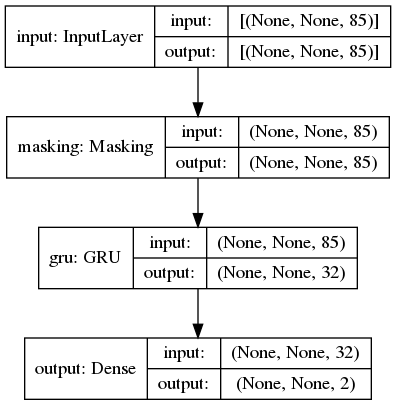

In [11]:
tf.keras.utils.plot_model(
    model, 
    f"figures/GRU_classifier_model.png", 
    show_shapes=True)

In [12]:
model.summary()

Model: "GRU_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None, 85)]        0         
_________________________________________________________________
masking (Masking)            (None, None, 85)          0         
_________________________________________________________________
gru (GRU)                    (None, None, 32)          11424     
_________________________________________________________________
output (Dense)               (None, None, 2)           66        
Total params: 11,490
Trainable params: 11,490
Non-trainable params: 0
_________________________________________________________________


### adversarial-regularized model

In [13]:
model_file = f"{results_dir}/models/GRU_classifier_adv_model"
history_file = f"{results_dir}/models/GRU_classifier_model_adv_history"
if os.path.exists(model_file):
    # load the model
    adv_model = tf.keras.models.load_model(model_file)
    adv_history = json.load(open(history_file, 'r'))
    
else:
    # build, train and save the adv_model
    '''
    base model
    '''
    base_model = get_GRU_classifier_model(
        X_train, 
        args, 
        regularizer)

    '''
    configurations
    '''
    adv_config = nsl.configs.make_adv_reg_config(
        multiplier=args.adv_multiplier,
        adv_step_size=args.adv_step_size,
        adv_grad_norm=args.adv_grad_norm,
    #     pgd_iterations=3,
    #     pgd_epsilon=0.001
    )

    '''
    building adv-model
    '''
    adv_model = nsl.keras.AdversarialRegularization(
        base_model,
        label_keys=['label'],
        adv_config=adv_config
    )

    '''
    training
    '''
    adv_model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=optimizer,
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

    then = time.time()
    adv_history = adv_model.fit(
        x={'input': X_train, 'label': y_train}, 
        epochs=args.num_epochs,
        validation_split=args.validation_split,
        batch_size=args.batch_size,
        verbose=1)
    print('--- train time =  %0.4f seconds ---' %(time.time() - then))

    '''
    saving model
    '''
    tf.keras.models.save_model(adv_model, model_file)
    adv_history = adv_history.history
    json.dump(adv_history, open(f"{history_file}", 'w'))

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
27/27 [==============================] - 12s 137ms/step - loss: 2.4247 - sparse_categorical_accuracy: 0.5293 - sparse_categorical_crossentropy: 0.7410 - scaled_adversarial_loss: 0.7719 - val_loss: 2.1206 - val_sparse_categorical_accuracy: 0.6439 - val_sparse_categorical_crossentropy: 0.6455 - val_scaled_adversarial_loss: 0.8564
Epoch 2/100
27/27 [==============================] - 3s 98ms/step - loss: 1.8547 - sparse_categorical_accuracy: 0.5763 - sparse_categorical_crossentropy: 0.6860 - scaled_adversarial_loss: 0.7001 - val_loss: 1.7760 - val_sparse_categorical_accuracy: 0.6620 - val_sparse_categorical_crossentropy: 0.63

INFO:tensorflow:Assets written to: /home/govindas/explainable-ai/results/models/GRU_classifier_adv_model/assets


INFO:tensorflow:Assets written to: /home/govindas/explainable-ai/results/models/GRU_classifier_adv_model/assets


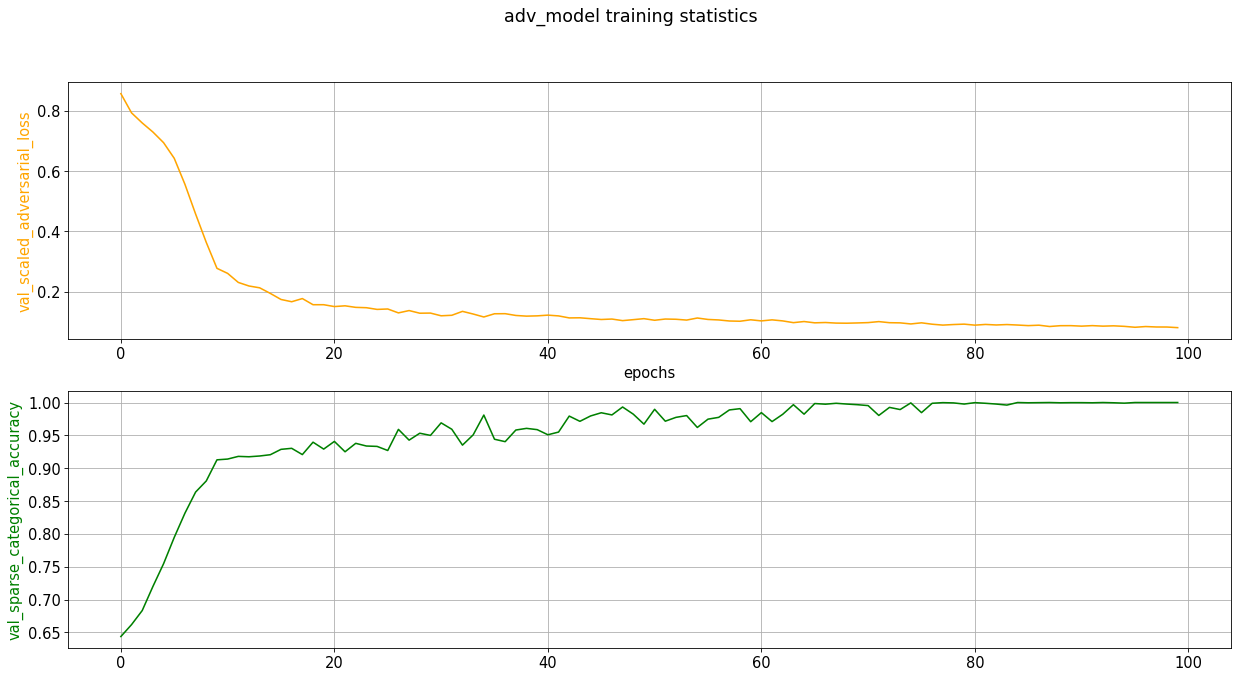

In [14]:
cm = 1 #1/2.54
nrows, ncols = 2, 1
fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(20*ncols*cm, 5*nrows*cm), 
    sharex=False,
    sharey=False,
    dpi=75)

plt.suptitle(f"adv_model training statistics")

ax = axs[0]
ax.plot(adv_history['val_scaled_adversarial_loss'], color='orange')
ax.set_ylabel(f"val_scaled_adversarial_loss", color='orange')
ax.set_xlabel(f"epochs")
ax.grid(True)

ax = axs[1]
ax.plot(adv_history['val_sparse_categorical_accuracy'], color='green')
ax.set_ylabel(f"val_sparse_categorical_accuracy", color='green')
ax.grid(True)

In [15]:
adv_model.evaluate(x={'input': X_test, 'label': y_test})

68/68 [==============================] - 4s 53ms/step - loss: 0.1926 - sparse_categorical_accuracy: 1.0000 - sparse_categorical_crossentropy: 0.0750 - scaled_adversarial_loss: 0.0811


[0.19264911115169525, 1.0, 0.07501006126403809, 0.08107791095972061]

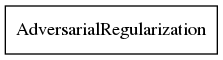

In [16]:
tf.keras.utils.plot_model(
    adv_model, 
    f"figures/GRU_classifier_adv_model.png", 
    show_shapes=True)

In [17]:
adv_model.summary()

Model: "AdversarialRegularization"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GRU_classifier (Functional)  (None, None, 2)           11490     
Total params: 11,492
Trainable params: 11,490
Non-trainable params: 2
_________________________________________________________________
